# Generate Avalanche Data 

Create a folder for the data

In [3]:
!mkdir 'speck_32_64'

mkdir: cannot create directory ‘speck_32_64’: File exists


Generate `number_of_samples = 300_000` avalanche units (this takes about one minute in Google Colab):

In [8]:
number_of_samples = 300_000

from avalanche_data_generator.speck_32_64 import speck_k64_p32_o32_r22 as data_generator
import numpy as np

dataset = data_generator.generate_avalanche_dataset(int(number_of_samples))

np.save(f"speck_32_64/round6_sequences300k.npy", dataset[6]) # please note that we start counting the rounds from 0, i.e. round id 6 means analyzing round 7/22 

# Choose Workspace Folder

In [9]:
# choose where to save the analysis data 
# this folder contains the configuration file, which points out the dataset and GPU configuration to use
savepath = 'demo_speck32_round7'

# Check Hardware Resources
The available resources can be explored by using for example the `ray.available_resources()` or `nvidia-smi`:

In [10]:
import ray
ray.init()
ray.available_resources()

Package pickle5 becomes unnecessary in Python 3.8 and above. Its presence may confuse libraries including Ray. Please uninstall the package.
2022-10-06 09:09:02,785	INFO worker.py:1518 -- Started a local Ray instance.


{'CPU': 128.0,
 'GPU': 5.0,
 'memory': 295037554484.0,
 'node:172.31.102.81': 1.0,
 'object_store_memory': 130730380492.0}

In [11]:
!nvidia-smi

Thu Oct  6 09:09:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      On   | 00000000:01:00.0 Off |                    0 |
| N/A   79C    P0   263W / 275W |  18060MiB / 40537MiB |     97%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  A100-SXM4-40GB      On   | 00000000:47:00.0 Off |                    0 |
| N/A   

# Run NNBits Analysis

In [30]:
#============ run the analysis ============
!python -m nnbits.run --savepath '{savepath}'

2022-09-23_14h11m26s 	 started to load data from harddisk...
2022-09-23_14h11m27s 	 finished.
|                             | value                                |
|:----------------------------|:-------------------------------------|
| DATAPATH                    | speck_32_64/round6_sequences300k.npy |
| NEURAL_NETWORK_MODEL        | gohr_generalized                     |
| NEURAL_NETWORKS             | 100                                  |
| SELECT_BITS_STRATEGY        | random                               |
| INPUT_DATA_OP               | zero                                 |
| N_RANDOM_BITS               | 63                                   |
| N_GPUS                      | 4                                    |
| N_ACTORS_PER_GPU            | 4                                    |
| GPU_PER_ACTOR               | 0.25                                 |
| CPU_PER_ACTOR               | 5                                    |
| N_EPOCHS                    | 5                     

# Analyze the results 

In [15]:
import numpy as np

# the file-manager is a simple module which knows under which path to search for e.g. the test_accuracies:
from nnbits.filemanager import FileManager
# given a file-manager, the get_X function loads all the test_accuracies from the analysis above into a single array:
from nnbits.bitanalysis import get_X

In [22]:
F = FileManager('demo_speck32_roundid6') 
X = get_X(F)
# X contains one row for each of the `N` neural network and one column for each of the `n` bits:
X.shape

(100, 1024)

In [23]:
# the bit accuracies are calculated by taking the mean over all neural networks which predict the particular bit 
# (axis=0):
# (the following three lines catch a runtime warning if a mean-calculation is empty. This happens if not all bits have been analyzed yet.)
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    bit_accuracies = np.nanmean(X, axis=0)

In [24]:
import pandas as pd
df = pd.DataFrame({'bit': np.arange(1024), 
                   'mean accuracy': bit_accuracies})

df.sort_values('mean accuracy', ascending=False)

,bit,mean accuracy
716,716,0.506620
732,732,0.505840
640,640,0.501772
685,685,0.501752
947,947,0.501689
...,...,...
157,157,0.498280
197,197,0.498236
819,819,0.498215
764,764,0.498094


# Visualize the Results 

Text(0, 0.5, 'validation accuracy')

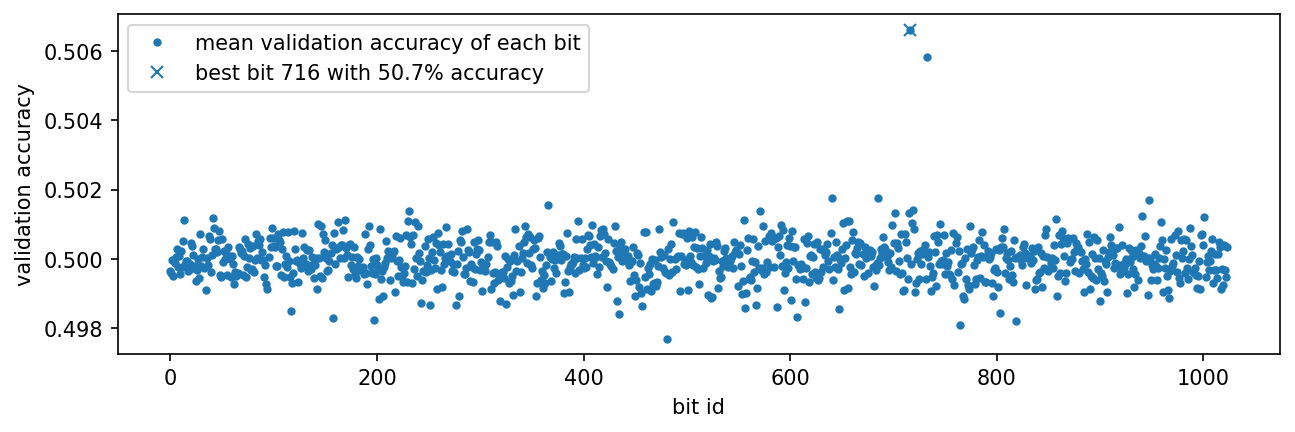

In [25]:
import matplotlib.pyplot as plt

# here we visualize the obtained `bit_accuracies`:
plt.figure(figsize=(10, 3), dpi=150)
plt.plot(bit_accuracies, 'o', markersize=3, linestyle = 'None', label="mean validation accuracy of each bit")
# find bit with maximum accuracy
dfm = df[df['mean accuracy'] == max(df['mean accuracy'])]
plt.plot(dfm['bit'], dfm['mean accuracy'], marker='x', c='C0', linestyle = 'None', label=f"best bit {int(dfm['bit'])} with {float(dfm['mean accuracy'])*100:.1f}% accuracy")

plt.legend(loc='upper left')
plt.xlabel('bit id')
plt.ylabel('validation accuracy')